# INTRODUCCION


En este proyecto se analizara información proveniente de una base de datos de viajes en taxi de Chicago, complementada con registros meteorológicos y resultados de consultas SQL específicas. El objetivo principal sera comprender patrones de comportamiento de los pasajeros, evaluar la demanda por empresa y por barrio, y determinar si las condiciones climáticas influyen en la duración de los viajes, especialmente en rutas clave como Loop Aeropuerto Internacional O’Hare.


# Datos meteorológicos
Primero extraemos información del clima desde una página HTML usando pandas.


In [39]:
import pandas as pd

url = "https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html"

weather_records = pd.read_html(
    url,
    attrs={"id": "weather_records"}
)[0]

weather_records

,Date and time,Temperature,Description
0,2017-11-01 00:00:00,276.15,broken clouds
1,2017-11-01 01:00:00,275.70,scattered clouds
2,2017-11-01 02:00:00,275.61,overcast clouds
3,2017-11-01 03:00:00,275.35,broken clouds
4,2017-11-01 04:00:00,275.24,broken clouds
...,...,...,...
692,2017-11-29 20:00:00,281.34,few clouds
693,2017-11-29 21:00:00,281.69,sky is clear
694,2017-11-29 22:00:00,281.07,few clouds
695,2017-11-29 23:00:00,280.06,sky is clear


# Consultas SQL

Aquí se presentan las consultas realizadas en SQL para obtener los datos necesarios para el análisis posterior.
Las consultas incluyen:
1. viajes por empresa,
2. viajes de empresas “Yellow” o “Blue”,
3. empresas más populares vs “Other”,
4. identificación de Loop y O’Hare,
5. clasificación del clima como Good/Bad,
6. viajes Loop → O’Hare los sábados.


# Análisis Exploratorio de Datos

En esta sección importo los resultados SQL:
- `project_sql_result_01.csv` contiene el número de viajes por empresa.
- `project_sql_result_04.csv` contiene el número promedio de viajes finalizados por barrio en noviembre de 2017.

Reviso sus primeras filas, estructura y tipos de datos.

In [40]:
import pandas as pd

companies = pd.read_csv('/datasets/project_sql_result_01.csv')
neighborhoods = pd.read_csv('/datasets/project_sql_result_04.csv')

display(companies.head())
companies.info()

display(neighborhoods.head())
neighborhoods.info()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


Viajes por empresa 

En esta sección analizo cuántos viajes realizó cada empresa de taxis durante el 15 y 16 de noviembre de 2017.

Primero ordeno las compañías por número de viajes y luego construyo un gráfico de barras para visualizar qué empresas concentran la mayor demanda.

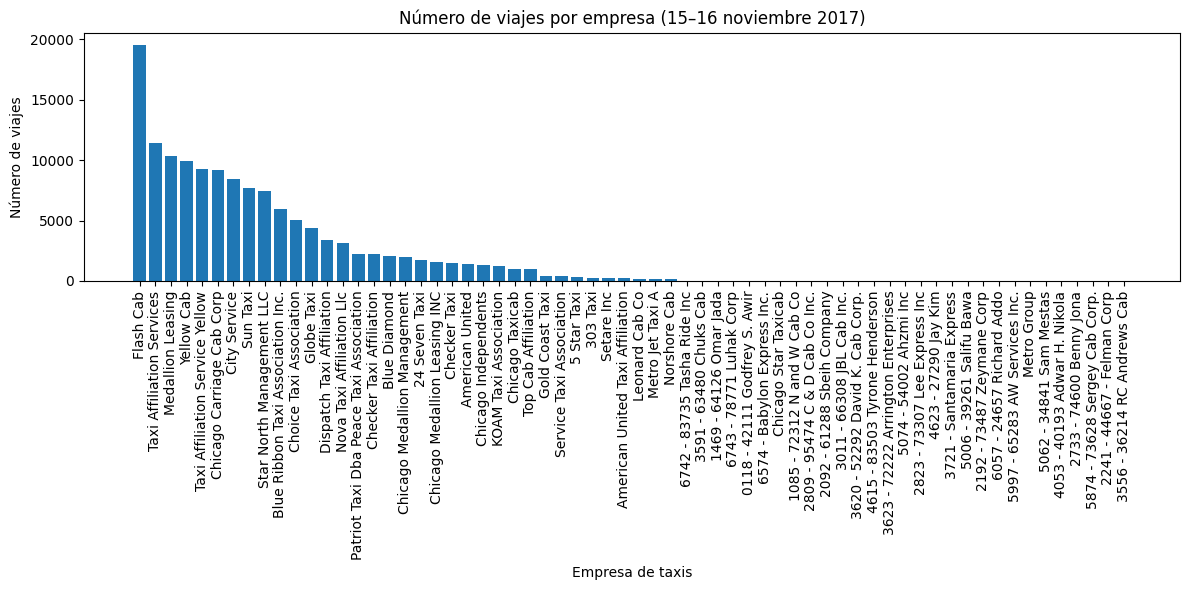

In [41]:
import matplotlib.pyplot as plt

companies_sorted = companies.sort_values('trips_amount', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(companies_sorted['company_name'], companies_sorted['trips_amount'])
plt.xticks(rotation=90)
plt.xlabel('Empresa de taxis')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por empresa (15–16 noviembre 2017)')
plt.tight_layout()
plt.show()


- Flash Cab fue la empresa con mayor número de viajes.  
- Taxi Affiliation Services y Medallion Leasing ocupan el segundo y tercer lugar.  
- Yellow Cab y compañías relacionadas también muestran alta actividad.  
- Existe una fuerte concentración del mercado en pocas empresas.


Top 10 barrios por finalización de viaje

Aquí identifico los 10 barrios con mayor número de viajes finalizados durante noviembre de 2017.  
Esto permite conocer las zonas con mayor actividad y demanda, información útil para la estrategia operativa de Zuber.

A continuación, ordeno los barrios por el promedio de viajes y visualizo los 10 primeros.


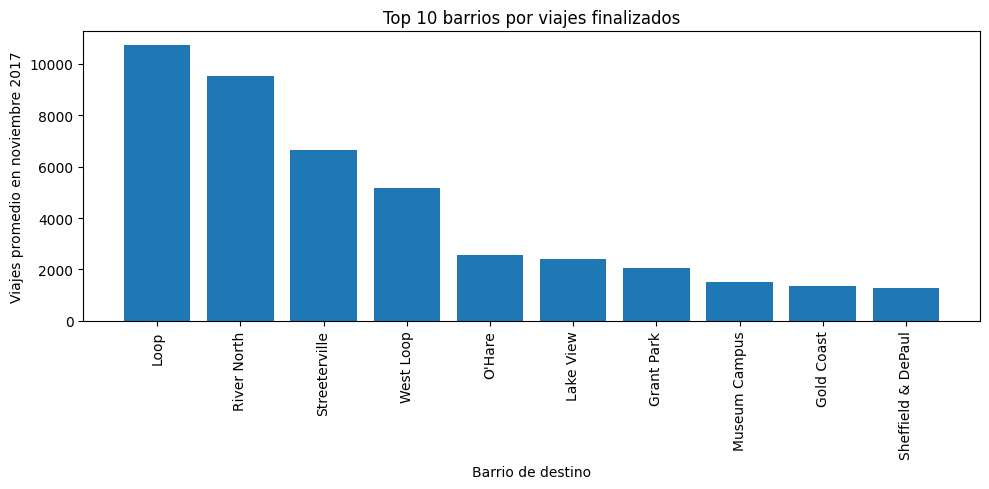

In [42]:

top10_neigh = neighborhoods.sort_values('average_trips', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(top10_neigh['dropoff_location_name'], top10_neigh['average_trips'])
plt.xticks(rotation=90)
plt.xlabel('Barrio de destino')
plt.ylabel('Viajes promedio en noviembre 2017')
plt.title('Top 10 barrios por viajes finalizados')
plt.tight_layout()
plt.show()



- Loop y River North son los barrios con mayor número de viajes.  
- Streeterville y West Loop también tienen una actividad destacada.  
- O’Hare aparece en el top 5, indicando lo importante que es la ruta hacia el aeropuerto.  
- Estos barrios son óptimos para estrategias de alta disponibilidad de vehículos para Zuber.


# Prueba de hipótesis

Carga del dataset para la prueba de hipótesis

Este dataset contiene viajes que comienzan en Loop y terminan en O’Hare los sábados.  
Incluye:

- `start_ts`: fecha/hora de inicio  
- `weather_conditions`: Good / Bad  
- `duration_seconds`: duración del viaje en segundos  

Primero convierto columnas a los tipos adecuados.

In [43]:
trips_weather = pd.read_csv('/datasets/project_sql_result_07.csv')

trips_weather['start_ts'] = pd.to_datetime(trips_weather['start_ts'])
trips_weather['duration_seconds'] = trips_weather['duration_seconds'].astype(float)

trips_weather.head()


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


Preparación de datos

Divido el dataset en dos grupos independientes:
- viajes realizados con clima “Good”
- viajes realizados con clima “Bad”

Esto permitirá comparar la duración promedio entre ambos grupos.

In [44]:

from scipy import stats

good = trips_weather.loc[trips_weather['weather_conditions']=='Good', 'duration_seconds']
bad = trips_weather.loc[trips_weather['weather_conditions']=='Bad', 'duration_seconds']

print('Good mean:', good.mean())
print('Bad mean:', bad.mean())
print('N Good:', len(good))
print('N Bad:', len(bad))



Good mean: 1999.6756756756756
Bad mean: 2427.2055555555557
N Good: 888
N Bad: 180


Hipótesis

**Hipótesis nula (H₀):**  
La duración promedio del viaje Loop → O’Hare los sábados es igual en clima Good y Bad.

**Hipótesis alternativa (H₁):**  
La duración promedio cambia dependiendo del clima (Good ≠ Bad).

**Nivel de significación utilizado:** α = 0.05

**Tipo de prueba:**  
Prueba t de Student para dos muestras independientes (Welch).  
Se usa porque:
- la variable es continua,
- los grupos son independientes,
- los tamaños no son iguales,
- y las varianzas pueden diferir.


In [45]:
results = stats.ttest_ind(bad, good, equal_var=False)

results


Ttest_indResult(statistic=7.186034288068629, pvalue=6.738994326108734e-12)

El p-valor obtenido es extremadamente pequeño (~6.7e-12), menor que α = 0.05.

**Conclusión:**  
Rechazamos la hipótesis nula.  
La duración promedio del viaje Loop → O’Hare los sábados *sí cambia* en función del clima.

En promedio, los viajes en clima **Bad** son más largos que en clima **Good**, lo cual sugiere que lluvia y tormentas afectan significativamente el tráfico.


# Conclusiones 

El análisis realizado me permitió identificar patrones clave del sistema de viajes en Chicago. Observando que la demanda está concentrada en unas pocas empresas de taxis, lo que evidencia un mercado competitivo pero dominado por ciertos actores. También se identificaron los barrios con mayor flujo de viajes, destacando Loop, River North y Streeterville como zonas de alta actividad y O’Hare como un destino fundamental. La integración de datos climáticos con información de viajes mostró que el clima adverso afecta de manera significativa la duración de los trayectos, especialmente en rutas críticas como Loop → O’Hare. Esto confirma que las condiciones externas influyen directamente en el comportamiento operativo y en los tiempos de servicio.

Finalmente puedo recomendar que Zuber concentre su disponibilidad de conductores en Loop, River North, Streeterville y West Loop, ya que representan los principales puntos de origen y destino, tambien que se establezaca presencia constante de conductores en O’Hare y evaluar modelos de tarifa fija para mejorar la experiencia del usuario.

Dado que el clima adverso extiende significativamente la duración de los viajes, se recomienda incorporar datos meteorológicos en los algoritmos de estimación de tiempo de llegada (ETA).